# Lecture Material Processing and Retrieval System

This notebook focuses on processing mechanical engineering lecture materials to extract, clean, and organize content for semantic search and generation.

In [1]:
## Set up 
# Add the project root to sys.path
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_root)

## 1. Processing Lecture Material
### 1.1 Pdf Extraction
This section focuses on processing PDFs by converting them into individual images and saving the content for further analysis.


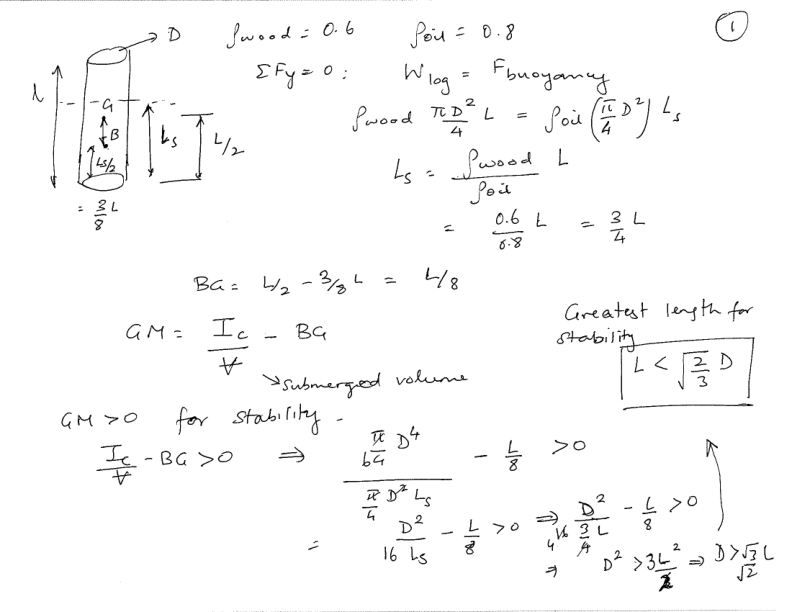

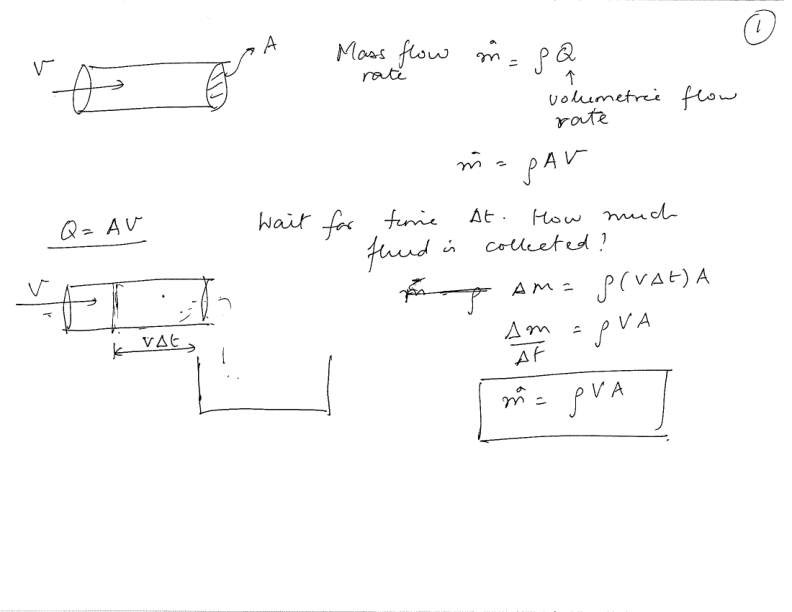

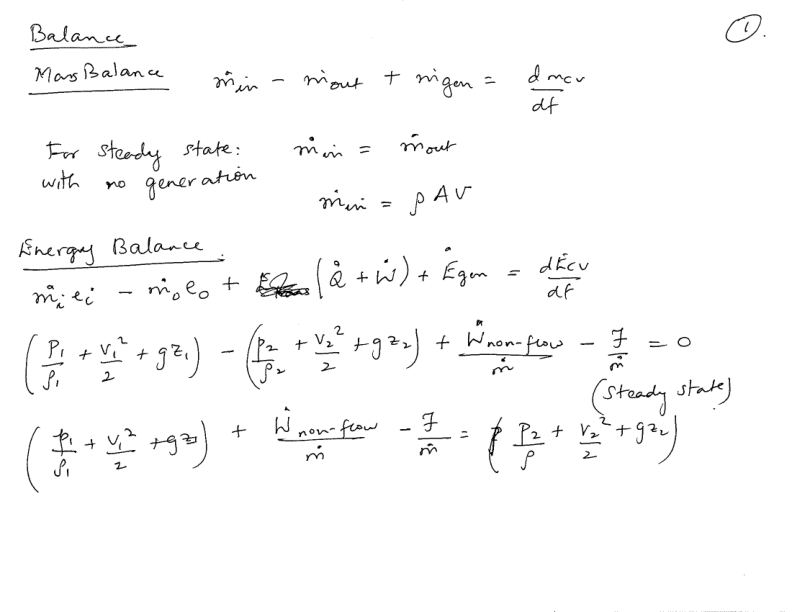

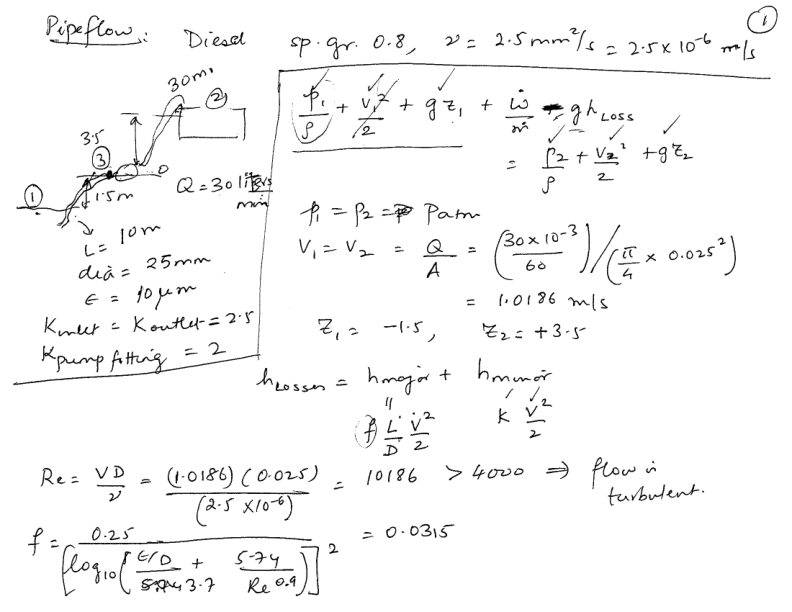

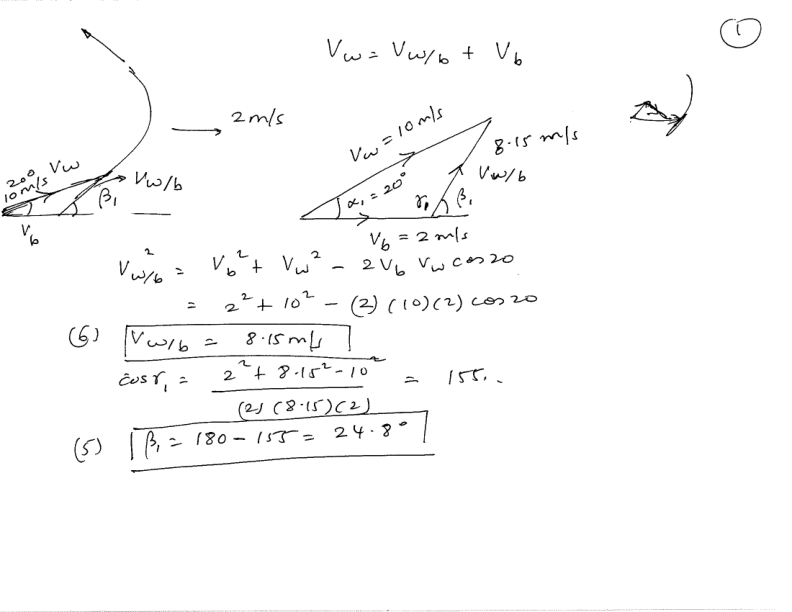

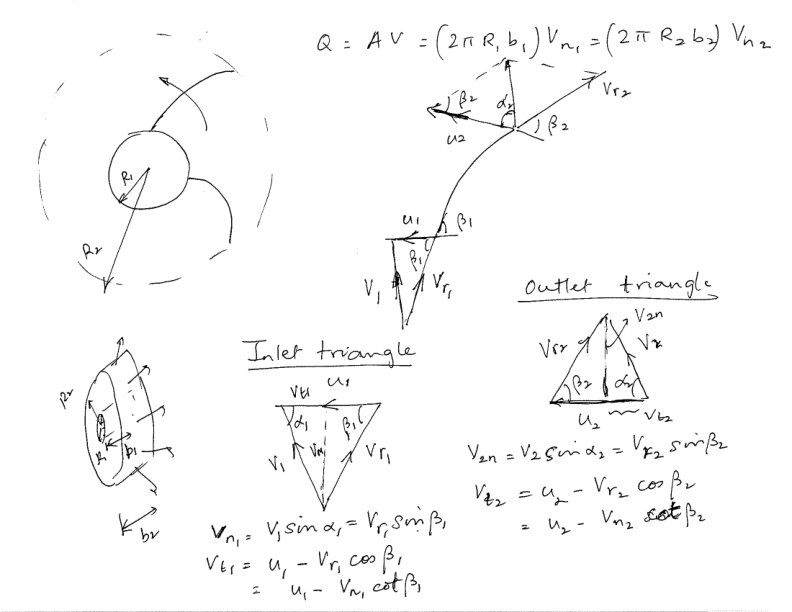

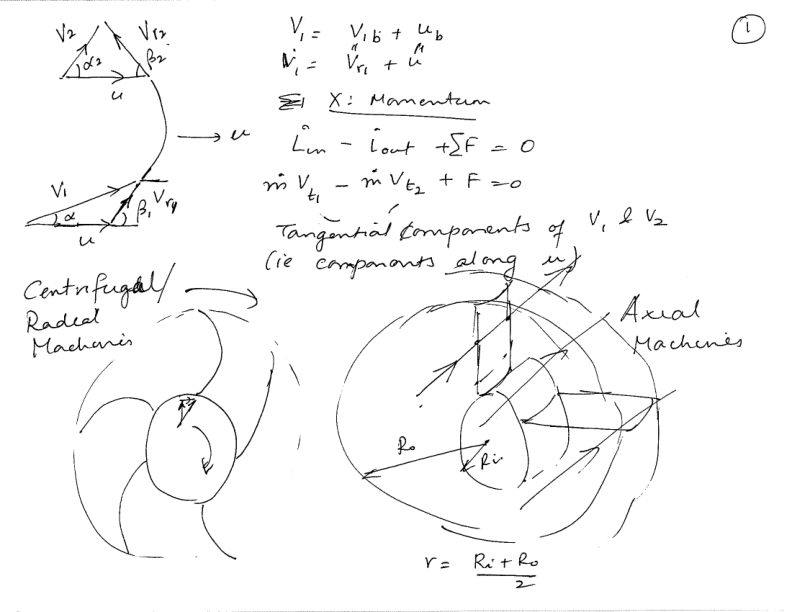

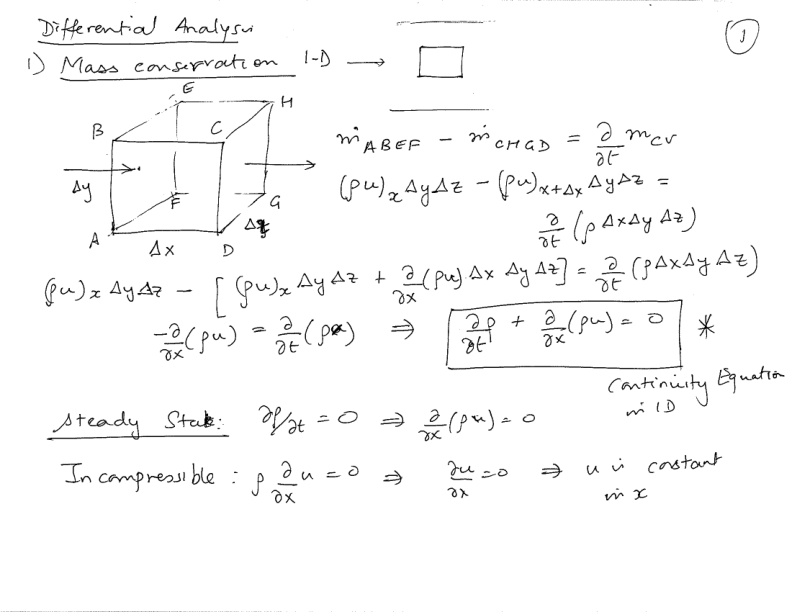

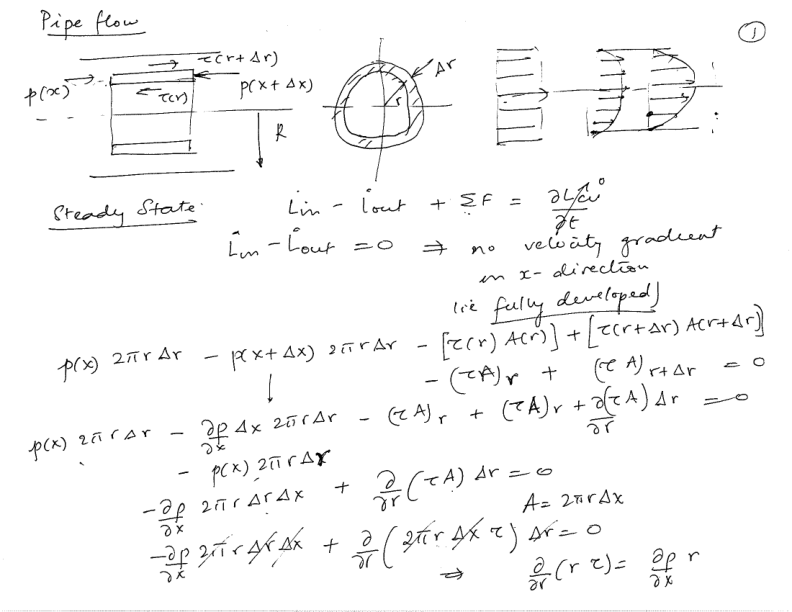

Summary
*************************
Folder Created at: lecture_images\Lecture_02_03
New Image Created: Lecture_02_03_page_1.png
New Image Created: Lecture_02_03_page_2.png
New Image Created: Lecture_02_03_page_3.png
New Image Created: Lecture_02_03_page_4.png
New Image Created: Lecture_02_03_page_5.png
New Image Created: Lecture_02_03_page_6.png
New Image Created: Lecture_02_03_page_7.png
New Image Created: Lecture_02_03_page_8.png
New Image Created: Lecture_02_03_page_9.png
New Image Created: Lecture_02_03_page_10.png
New Image Created: Lecture_02_03_page_11.png
New Image Created: Lecture_02_03_page_12.png
New Image Created: Lecture_02_03_page_13.png

Folder Created at: lecture_images\Lecture_02_06
New Image Created: Lecture_02_06_page_1.png
New Image Created: Lecture_02_06_page_2.png
New Image Created: Lecture_02_06_page_3.png
New Image Created: Lecture_02_06_page_4.png
New Image Created: Lecture_02_06_page_5.png
New Image Created: Lecture_02_06_page_6.png
New Image Created: Lecture_02

In [33]:
import fitz
import os
from IPython.display import Image, display

# Directory to store the extracted lecture images
content_folder ='lecture_images'
os.makedirs(content_folder,exist_ok=True)

# Path containing lecture pdfs
## Go up to levels directory
parent_directory = os.path.abspath(os.path.join(os.getcwd(),'..','..'))
pdf_path = r'test_images\lecture_collection'
pdf_path = os.path.join(parent_directory,pdf_path)

# Collect all the pdf files 
file_paths = []
for root, dirs, files in os.walk(pdf_path):
    file_paths.extend(
        [os.path.join(root, file) for file in files if file.endswith('.pdf')]
    )
# Initialize a summary string to log the process
summary = f"Summary\n{'*' * 25}\n"

for filename in file_paths:
    pdf_document = fitz.open(filename)  # Open the PDF
    
    # Create folder for the current PDF's extracted images
    pdf_name = os.path.splitext(os.path.basename(filename))[0].replace(" ","_")  # Extract the PDF name without extension
    folder_path = os.path.join(content_folder, pdf_name)
    if os.path.exists(folder_path):
        summary += f"Folder Already Exist at: {folder_path}\n"
    else:
        os.makedirs(folder_path, exist_ok=True)  # Ensure the directory exists
        summary += f"Folder Created at: {folder_path}\n"
        
    # process each page in the pdf
    for page_number in range(pdf_document.page_count):
        page = pdf_document.load_page(page_number)
        page.set_rotation(45)
        
        # Render the page and save to the output directory
        pix = page.get_pixmap()
        img_filename = f"{pdf_name}_page_{page_number + 1}.png"
        output_path = os.path.join(folder_path, img_filename)
        pix.save(output_path)
        
        # Outputs the first page of each document just for checking
        ## Comment in or out depending if you want to show it 
        if page_number == 0:
            display(Image(filename=output_path))
            
        
        summary += f"New Image Created: {img_filename}\n"
    summary+='\n'
# Print the summary log
print(summary)

### 1.2 Extract Content from Lecture  

- **Goal**: Process mechanical engineering lecture materials to extract meaningful content across multiple aspects:  
  - **Summaries**: Generate concise overviews of the content.  
  - **Key Concepts**: Identify critical ideas, principles, and definitions.  
  - **Text**: Extract detailed content presented in the lecture.  
  - **Equations**: Capture mathematical expressions for analysis or inclusion in summaries.  
  - **Diagrams, Drawings, and Charts**: Identify visual elements such as diagrams, images, and charts.  

#### Structure of Outputs Using Pydantic Models  

To maintain consistency and clarity, **Pydantic models** will define structured outputs for the extracted data.  

- **`LectureSummary` Model**:
  - **Purpose**: Provides a standardized structure to represent lecture details.
  - **Key Fields**:
    - `lecture_name`: Title of the lecture.
    - `lecture_subtitle`: A concise subtitle summarizing the lecture.
    - `summary`: A detailed overview, supporting LaTeX for mathematical symbols.
    - `key_concepts`: Key ideas covered, formatted with LaTeX if needed.
    - `foundational_concepts`: Prerequisite concepts the lecture builds upon.
    - `search_keywords`: Relevant search queries (up to 3) for external references. (Not used)

This model ensures a uniform schema for storing and retrieving lecture data, supporting efficient downstream tasks like summarization, retrieval, and visualization.  

In [22]:
from pydantic import BaseModel,Field
from typing import List, Dict, Optional
from langchain import hub

# Define Structure Output Models for Lecture Summary (Whole PDF)
class KeyWord(BaseModel):
    keyword:str = Field(...,description="Keyword")
    description: str = Field(...,description = "Description of the keyword.Use LaTeX for any mathematical symbols or equations. ")
class LectureSummary(BaseModel):
    lecture_name: str = Field(...,description = "A concise and descriptive title of the lecture")
    lecture_subtitle: str= Field (...,description = "A subtitle that is essentially a super consise summary meant to add more information about the general lecture")
    summary: str = Field(..., description="A summary of the lecture material, describing the essence of what the lecture was about. Use LaTeX for any mathematical symbols or equations.")
    key_concepts: List[KeyWord] = Field(..., description="A list of key concepts covered in the lecture. Use LaTeX for any mathematical symbols or equations.")
    foundational_concepts: List[KeyWord] = Field(..., description="A list of prerequisite concepts that the lecture builds upon. Use LaTeX for any mathematical symbols or equations.")
    search_keywords: List[str] = Field(..., description="Return a list of relevant search queries which will be used to find external references for generating additional info", max_items=3)
    
lecture_summary_prompt = hub.pull("lecture-summary")
print('Prompt : Lecture Summary')
print(lecture_summary_prompt[0].pretty_print())

Prompt : Lecture Summary
================================ System Message ================================


**Prompt for Analyzing Lecture Content**
You are tasked with analyzing the **entire** provided lecture slides on a specific class topic. Follow the instructions below to generate a detailed analysis, and return the results as a structured JSON object with the specified keys:
### 0. **Lecture Title**:
   - Generate a concise, descriptive title that encapsulates the primary focus and subject of the lecture. Ensure that it accurately reflects the core content.
### 1. **Lecture Subtitle**:
   - Provide a short subtitle that adds further context to the title. The subtitle should briefly summarize the lecture's scope, giving additional insight into the key points or themes covered.
### 2. **Summary**:
   - Offer a clear, concise, and comprehensive summary of the **entire lecture material**, capturing the most important concepts, ideas, and discussions. Focus on the overall flow and cor

In [118]:
# Define Structure Output Model for Individial Pages
class SinglePage(BaseModel):
    summary: str = Field(..., description="A summary of the lecture material, describing the essence of what the lecture was about. Use LaTeX for any mathematical symbols or equations.And the description of charts and images")
    text: str = Field(..., description="Extract all content from the lecture slide, including equations, notes, and other details. Use LaTeX delimiters for any mathematical content. Ensure that no content is omitted.")
    image_description: Optional[str] = Field(...,description='If any images, charts or diagrams are present describe them and include the text "DESCRIPTION OF THE IMAGE OR CHART"')
single_page_prompt = hub.pull("rag-lecture-extract")
print('Prompt : Single Page Summary')
print(single_page_prompt[1].pretty_print())

Prompt : Single Page Summary
================================ Human Message =================================

You are tasked with extracting all content from engineering lecture slides, including text, equations, questions, notes, images, diagrams, and charts. Please adhere to the following guidelines:

1. Generate a concise summary of the content depicted on each lecture slide.
2. Extract all relevant content, including text, equations, and questions.
3. For any mathematical formulas, use LaTeX formatting: enclose block-level math with $$ and inline math with $.
4. If there are images, diagrams, or charts present on the slide, describe them clearly and include the text "DESCRIPTION OF THE IMAGE OR CHART" to indicate the nature of the visual content. If there are no images, return None.
None


In [119]:
import re
from src.llm_module_generator.image_extraction.image_llm import ImageLLMProcessor
import asyncio
import json 

content_path = os.path.join(os.getcwd(),content_folder)
def natural_sort_key(filename):
    return [int(part) if part.isdigit() else part for part in re.split(r'(\d+)', filename)]

# Check if everything is loaded right
async def validate_summary(summary):
    try:
        if isinstance(summary,dict):
            return summary
        validated_sum = json.loads(summary)
        return validated_sum
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e}. Attempting to clean the summary.")
        cleaned_sum = summary[:e.pos]  # Trim at the error position
        try:
            validated_summary = json.loads(cleaned_sum)
            return validated_summary
        except Exception as e:
            print(f"Failed to clean and validate the summary: {e}")
            return {"error": "Malformed summary"}
        
    
async def process_lecture(path:str):
    # Define Image Processors
    ## Whole Lecture Extractor
    extract_lecture_summary= ImageLLMProcessor(
    prompt = lecture_summary_prompt,
    response = LectureSummary, # type: ignore
    model = 'gpt-4o')
    # Single page Extractor
    extract_page_summary = ImageLLMProcessor(
        prompt = single_page_prompt,
        response=SinglePage, # type: ignore
        model = 'gpt-4o')
    
    async def process_entire_lecture(root,files):
        data = {}
        try:
            pdf_name = files[0].split('_page')[0]
            lecture_files = sorted([os.path.join(root, file) for file in files], key=natural_sort_key)
            lecture_summary = await extract_lecture_summary.send_request(lecture_files)
            all_page_summaries = []
            for file in lecture_files:
                try:
                    page_data = {}
                    page_num = file.split('_page_')[1].split('.png')[0]
                    file_path = os.path.join(root, file)
                    single_page_summary = await extract_page_summary.send_request([file_path])
                    validated_summary = await validate_summary(single_page_summary)
                    page_data[page_num] = [
                        {'page_summary': validated_summary},
                        {'file_path': file_path}
                        ]
                    all_page_summaries.append(page_data)
                except Exception as e:
                    print(f"Error processing file {file}: {e}")
            data[pdf_name] = [
                {'pdf_path': root},
                {'lecture_summary': lecture_summary},
                {'all_page_summaries': all_page_summaries}
                ]
            return data
        except Exception as e:
            print(f"Error processing files in {root}: {e}")
            return None
    
    tasks = []
    for root,dirs,files in os.walk(path):
        if not dirs:
            if files:
                tasks.append(process_entire_lecture(root,files))
    results = await(asyncio.gather(*tasks))
    return results
results = await process_lecture(content_path)  

In [122]:
print(results)
# Save File as Json 
with open("lecture_data.json", "w") as json_file:
    json.dump(results, json_file, indent=4)
    print('Saved results as JSON')

[{'Lecture_02_03': [{'pdf_path': 'c:\\Users\\lberm\\OneDrive\\Documents\\Github\\mechedu1.0\\src\\notebooks\\lecture_images\\Lecture_02_03'}, {'lecture_summary': {'lecture_name': 'Fluid Dynamics: Stability and Motion', 'lecture_subtitle': 'Analyzing Stability in Fluids and Motion of Containers', 'summary': 'The lecture focuses on the principles of fluid dynamics, particularly examining stability and motion in fluids and containers. It begins with the analysis of buoyancy and stability in floating objects, exploring the conditions for stability based on the center of gravity and buoyancy. The lecture continues with the study of accelerating containers, deriving the equations of motion and the effects of acceleration on fluid surfaces. It introduces the concept of pressure distribution in rotating fluids and the resulting parabolic surfaces. The volumetric flow rate equation is also discussed, highlighting units and conversion.', 'key_concepts': [{'keyword': 'Buoyancy and Stability', 'de

### 2: Load Documents and Create a vector store
Loading documents and creating a vector store. 
We are going to use the extracted information 

In [123]:
with open("lecture_data.json", "r") as json_file:  # Open in read mode
    data = json.load(json_file)

In [198]:
from langchain_core.documents import Document

def lecture_summary_doc(lecture_summary,pdf_path):
    lecture_name = lecture_summary.get('lecture_name', 'N/A')
    lecture_subtitle = lecture_summary.get('lecture_subtitle', 'N/A')
    summary = lecture_summary.get('summary', 'N/A')
    
    key_concepts = lecture_summary.get('key_concepts', [])
    foundational_concepts = lecture_summary.get('foundational_concepts', [])
    
    key_concepts_text = "\n".join(
                    [f"- {concept['keyword']}: {concept['description']}" for concept in key_concepts]
                )

    # Combine foundational concepts into a string
    foundational_concepts_text = "\n".join(
        [f"- {concept['keyword']}: {concept['description']}" for concept in foundational_concepts]
    )

    # Create the full description
    full_description = (
        f"Lecture Source {os.path.basename(pdf_path)}"
        f"Lecture Name: {lecture_name}\n"
        f"Summary: {summary}\n"
        f"Subtitle: {lecture_subtitle}\n\n"
        f"Key Concepts:\n{key_concepts_text}\n\n"
        f"Foundational Concepts:\n{foundational_concepts_text}"
    )
    
    doc = Document(
        page_content = full_description, 
        metadata = {
            'title': os.path.basename(pdf_path)+f'_{lecture_name}',
            'parent_file_path':pdf_path,
            'file_path':pdf_path,
            'source_type':'full_pdf'         
    }) 
    return doc
def single_page_doc(single_page_sums,pdf_path):
    documents = []
    for page in single_page_sums:
        for page_num,content in page.items():
            sum_dict = content[0].get('page_summary')
            filepath = content[1].get('file_path')
            print(sum_dict.get('text',''))
            page_description = f"""
            Page Source {os.path.basename(filepath)}
            Page Summary {sum_dict.get('summary','')}\n
            Content {sum_dict.get('text','')}
            image_description {sum_dict.get('image_description','')}\n"""
            doc = Document(
                page_content = page_description, 
                id = page_num,
                metadata = {
                    'title': os.path.basename(filepath),
                    'parent_file_path':pdf_path,
                    'file_path': filepath,
                    'source_type':'single_page'}) 
            documents.append(doc)
    return documents
            
documents = []
for d in data:
    for lecture, content in d.items():
        
        pdf_path = content[0].get('pdf_path')
        lecture_summary = content[1].get('lecture_summary')
        single_page_sums = content[2].get('all_page_summaries')
        
        lecture_document = lecture_summary_doc(lecture_summary,pdf_path)
        single_page_documents = single_page_doc(single_page_sums,pdf_path)
        
        documents.extend([lecture_document] + single_page_documents)     

\[ \rho_{wood} = 0.6 \quad \rho_{oil} = 0.8 \] \[ \Sigma F_y = 0; \quad W_{log} = F_{buoyancy} \] \[ \rho_{wood} \frac{\pi D^2}{4} L = \rho_{oil} \left( \frac{\pi}{4} D^2 \right) L_s \] \[ L_s = \frac{\rho_{wood}}{\rho_{oil}} L = \frac{0.6}{0.8} L = \frac{3}{4} L \] \[ BG = \frac{L}{2} - \frac{3}{8} L = \frac{L}{8} \] \[ GM = \frac{I_c}{V} - BG \] \[ \text{Submerged volume} \] \[ GM > 0 \quad \text{for stability} \] \[ \frac{I_c}{V} - BG > 0 \Rightarrow \frac{\pi}{64} D^4 \cdot \frac{1}{\frac{\pi}{4} D^2 L_s} - \frac{L}{8} > 0 \] \[ \Rightarrow \frac{D^2}{16 L_s} - \frac{L}{8} > 0 \Rightarrow \frac{D^2}{3L} - \frac{L}{8} > 0 \] \[ \Rightarrow D^2 > 3L^2 \Rightarrow D > L \frac{\sqrt{2}}{2} \] \[ \text{Greatest length for stability:} \quad L < \frac{\sqrt{2}}{3} D \]
\( \frac{\partial p}{\partial x} = -\rho a_x \) \( \frac{\partial p}{\partial y} = -\rho a_y \) \( \frac{\partial p}{\partial z} = -\rho (az + g) \) \( p @ \text{surface} = p_a \) \( ax \) \( dp = \frac{\partial p}{\partial

In [199]:
from uuid import uuid4
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma


uuids = [str(uuid4()) for _ in range(len(documents))]
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./lecture",  # Where to save data locally, remove if not necessary
)
vector_store.add_documents(documents=documents, ids=uuids)

['95b05b64-0d82-4ccc-8e12-3023e8d712d4',
 'e47d6e06-bc5a-40f9-8169-813778c56661',
 'b05b2097-2f6f-4e9d-a7e0-f574e38d74b4',
 '6f62a93e-5c8b-4518-ad2e-f745d8fc8670',
 'e5103577-9d5c-440c-9a1d-5a3093472241',
 '8a04d045-8302-4c3e-aa10-b920f748cd59',
 '1d946211-ef1b-497e-9795-00b701502bf7',
 '99e259bc-7708-4430-8c6a-dbb6c9e1ab84',
 'b97ad825-d3ab-47b4-8821-7a1a15ce9a61',
 '0c072898-368e-4027-8b90-b27956cd8589',
 '0a48b25a-d33e-49e8-99da-d1ec100c32fa',
 '3257e898-57a5-4a8e-ae7a-3f4e05158fd0',
 '1194cdd5-d092-40ed-9146-240a13566006',
 '6c6b33b0-ae8f-4e4a-b4bf-6b798b0921a2',
 '422698f5-128e-4c66-b169-aded5adfaabf',
 'f8cf2a90-6560-4ee2-8e9f-cd9e277e0cf5',
 '77b867c9-23dc-4136-a5e5-103583a14041',
 'b2758701-1751-43e4-a584-7b15c8bd7344',
 '46dd6d2d-d062-4dcc-bcf2-40c245537c60',
 'cefaf469-dfbf-4980-93e7-44612e0f58b3',
 'ef4477ac-9951-4c60-923d-bfd8b251c33e',
 'd27be8dd-595f-4ca9-a18e-9c6d9c3bb833',
 '49d44754-f912-4455-a941-50da161f4c93',
 '6e2891f8-9f1e-44fb-a634-ab80af32c333',
 'cc5a1406-8684-

In [179]:
results = vector_store.similarity_search(
    """What is transport phenomena""",
    k=2,
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

* Lecture Source Lecture_02_06Lecture Name: Fluid Flow and Conservation Principles
Summary: The lecture focuses on the fundamental principles of fluid dynamics, specifically exploring the conservation of mass, momentum, and energy within a control volume. It begins by introducing the concept of mass flow rate, emphasizing the relationship between density, velocity, and cross-sectional area. The lecture then covers the general balance equation for various quantities such as mass, energy, and momentum, detailing how these can be transferred, generated, or consumed within a system. The steady-state assumption is introduced, simplifying the balance equations under certain conditions. Applications of these principles are demonstrated through examples involving incompressible flow, the behavior of gases in a tank, and the use of tools like the Venturi meter and Pitot tube. The energy balance is further illustrated using Bernoulli's equation, which is then applied to practical situations like

## Creating a RAG Chatbot

In [204]:
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from typing_extensions import Annotated, TypedDict

llm = ChatOpenAI(model="gpt-4o-mini")

prompt = hub.pull('eng_tutor')

# Define state for application
class CitedAnswer(BaseModel):
    """Answer the user question based only on the given sources, and cite the sources used."""

    answer: str = Field(
        ...,
        description="The answer to the user question, which is based only on the given sources.",
    )
    citations: List[int] = Field(
        ...,
        description="The integer IDs of the SPECIFIC sources which justify the answer.",
    )

def format_docs_with_id(docs:List[Document])->str:
    formatted = [
        f"Source ID : {i} Source Name {doc.metadata['title']}\nArticle Snippet: {doc.page_content}"
        for i,doc in enumerate(docs)
    ]
    return "\n\n" + "\n\n".join(formatted)

class State(TypedDict):
    question: str
    context: List[Document]
    answer: CitedAnswer


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"],k=3)
    return {"context": retrieved_docs}


def generate(state: State):
    formatted_docs = format_docs_with_id(state["context"])
    messages = prompt.invoke({"question": state["question"], "context": formatted_docs})
    structured_llm = llm.with_structured_output(CitedAnswer)
    response = structured_llm.invoke(messages)
    return {"answer": response}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [205]:
result = graph.invoke({"question": "What are velocity triangles"})

result["answer"]

CitedAnswer(answer='Velocity triangles are graphical representations used in fluid dynamics, particularly in turbomachinery, to analyze the relationships between various velocity components of fluid flow relative to rotating blades. They help to resolve the absolute, relative, and peripheral velocities of the fluid as it passes through the machinery. Each triangle corresponds to an inlet or outlet condition and includes angles and velocity components that facilitate the understanding of how the fluid interacts with the rotating blades. For example, in a velocity triangle at the inlet, the absolute velocity (V), relative velocity (Vr), and peripheral velocity (u) are defined along with their respective angles (α for absolute and β for blade angle). This analysis is critical for calculating parameters such as power, torque, and pump head in turbomachinery.', citations=[0, 1, 2])